### RBF Network Regression

In [1]:
import pandas as pd
from processing_utils import *
from RBF import RBF
from rbf_optimization import objective
import optuna
from optuna.trial import Trial
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import random
%reload_ext autoreload
%autoreload 2

raw_dataset = pd.read_csv('./dataset/data.csv')

In [2]:
dataset = encode_smiles_column_of(
    prune_dataset_lines(
        raw_dataset,
        remove_nan_lines=False,
        remove_nan_cols=True,
        remove_duplicates=True
    ),
    strategy='count_encoding'
)

_, (X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test) = scale_data(*get_train_data(
    dataset,
    targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    random_state=7747,
    as_numpy=False
))

In [4]:
study = optuna.create_study(
    direction='minimize',
    study_name="RBF hyperparameters optimization"
)

study.optimize(
    lambda trial: objective(trial, (X_train, y_train, X_val, y_val)),
    n_trials=10,
    n_jobs=-1
)

rbf = RBF(study.best_params["n_clusters"], study.best_params["sigma"]).fit(X_train, y_train)
y_pred = rbf.predict(X_test)
print("Test mse =", mean_squared_error(y_test, y_pred))
print("Test R2 =", r2_score(y_test, y_pred))

[I 2022-06-21 21:37:18,113] A new study created in memory with name: RBF hyperparameters optimization
/home/gordon/.local/lib/python3.10/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-06-21 21:37:24,863] Trial 7 finished with value: 0.20335167831868828 and parameters: {'n_clusters': 30, 'sigma': 4.117947439866702}. Best is trial 7 with value: 0.20335167831868828.
[I 2022-06-21 21:37:26,256] Trial 0 finished with value: 0.433174653504907 and parameters: {'n_clusters': 42, 'sigma': 1.7464793096838414}. Best is trial 7 with value: 0.20335167831868828.
[I 2022-06-21 21:37:26,632] Trial 4 finished with value: 0.12124140927638716 and parameters: {'n_clusters': 44, 'sigma': 5.342124900267989}. Best is trial 4 with value: 0.12124140927638716.
[I 2022-06-21 21:37:28,798] Trial 3 finished with value: 0.137636996121061

Test mse = 0.009158181968164572
Test R2 = 0.9908333256643549


#### Performances w.r.t. training dataset size

In [12]:
N_ESSAIS = 50
mses = [[] for _ in range(N_ESSAIS)]
r2_scores = [[] for _ in range(N_ESSAIS)]
percentages = np.arange(0.2, 1, 0.01)
print(len(percentages))

80


In [15]:
cluster_numbers = []
standard_deviations = []
optimization = np.arange(start=0, stop=N_ESSAIS * len(percentages), step=1)

# this took 15 min on my machine with N_ESSAIS = 5
for k in range(N_ESSAIS):
    seed = random.randint(0, 10000)
    random_state = np.random.RandomState(seed)

    for p in percentages:
        
        _, (X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test) = scale_data(*get_train_data(
            dataset,
            targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
            random_state=random_state,
            as_numpy=False
        ))

        study = optuna.create_study(
            direction='minimize',
            study_name="RBF hyperparameters optimization for percentage p="+str(p)+" Essai="+str(k)
        )

        study.optimize(
            lambda trial: objective(trial, (X_train, y_train, X_val, y_val)),
            n_trials=10,
            n_jobs=-1
        )

        rbf = RBF(study.best_params["n_clusters"], study.best_params["sigma"]).fit(X_train, y_train)
        y_pred = rbf.predict(X_test)
        mses[k].append(mean_squared_error(y_test, y_pred))
        r2_scores[k].append(r2_score(y_test, y_pred))

        cluster_numbers.append(study.best_params["n_clusters"])
        standard_deviations.append(study.best_params["sigma"])

from pathlib import Path

path = Path('./results/rbf')
mses = np.array(mses)
r2_scores = np.array(r2_scores)

np.save(path/'rbf_mses_var_percentage', mses)
np.save(path/'rbf_scores_var_percentage', r2_scores)

[I 2022-06-21 21:36:37,532] A new study created in memory with name: RBF hyperparameters optimization for percentage p=0.1 Trial=0
/home/gordon/.local/lib/python3.10/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-06-21 21:36:42,799] Trial 7 finished with value: 0.994819422690855 and parameters: {'n_clusters': 26, 'sigma': 1.0311706317230234}. Best is trial 7 with value: 0.994819422690855.
[I 2022-06-21 21:36:43,450] Trial 5 finished with value: 0.9936569601146521 and parameters: {'n_clusters': 32, 'sigma': 2.704527812725988}. Best is trial 5 with value: 0.9936569601146521.
[I 2022-06-21 21:36:47,507] Trial 0 finished with value: 1.0136515073520722 and parameters: {'n_clusters': 92, 'sigma': 0.6414465215547857}. Best is trial 5 with value: 0.9936569601146521.
[I 2022-06-21 21:36:48,023] Trial 3 finished with 

KeyboardInterrupt: 

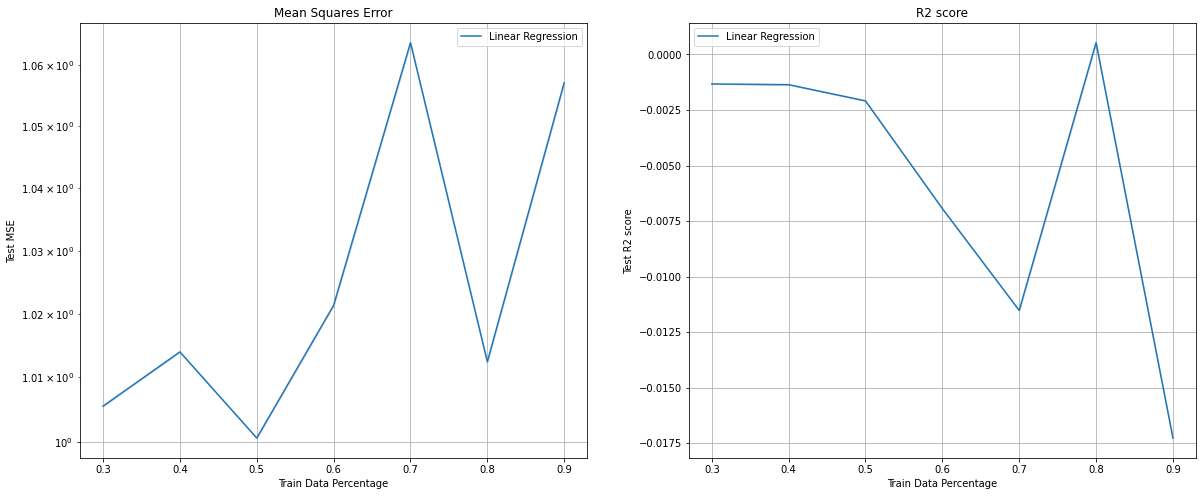

In [9]:
import matplotlib.pyplot as plt
from pathlib import Path

path = Path('./results/rbf')

#mses = np.array(mses)
#r2_scores = np.array(r2_scores)

mses = np.load(path/'rbf_mses_var_percentage.npy')
r2_scores = np.load(path/'rbf_scores_var_percentage.npy')

np.save(path/'rbf_mses_var_percentage', mses)
np.save(path/'rbf_scores_var_percentage', r2_scores)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Mean Squares Error")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test MSE")
plt.grid(True)

final_mses = np.mean(mses, axis=0)
mses_error = np.std(mses, axis=0)

# remove the fucky percentages
rows = np.abs(final_mses) < 10000
final_mses_chosen = final_mses[rows][2:]
mses_error_chosen = mses_error[rows][2:]
percentages_chosen = percentages[rows][2:]

plt.semilogy(percentages_chosen, final_mses_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(percentages_chosen, final_mses_chosen - mses_error_chosen, final_mses_chosen + mses_error_chosen, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')

plt.subplot(1, 2, 2)
plt.title("R2 score")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test R2 score")
plt.grid(True)
plt.yscale('linear')

final_r2_score = np.mean(r2_scores, axis=0)
r2_score_error = np.std(r2_scores, axis=0)

# remove fucky values
r2_rows = np.abs(final_r2_score) < 10000
final_r2_score_chosen = final_r2_score[r2_rows][2:]
r2_score_error_chosen = r2_score_error[r2_rows][2:]
r2_percentages_chosen = percentages[r2_rows][2:]

plt.plot(r2_percentages_chosen, final_r2_score_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(r2_percentages_chosen, final_r2_score_chosen - r2_score_error_chosen, final_r2_score_chosen + r2_score_error_chosen, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')
